In [2]:
#imports

import numpy as np
import shelve
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline


In [6]:
# reads in the initial conditions for each sim
# IC_table.csv is saved in the everything.ipynb, generated after executing the entire notebook

ic = QTable.read('IC_table.csv',format='ascii.csv')
sim_idx = ic['Sim #']
dMass_b = ic['Mass_b']
dMass_c = ic['Mass_c']
dRadius_b = ic['Radius_b']
dRadius_c = ic['Radius_c']
dSemi_b = ic['Semi_b_0']
dSemi_c = ic['Semi_c_0']
dEcc_b = ic['Ecc_b_0']
dEcc_c = ic['Ecc_c_0']
dInc_b = ic['Incl_b_0']
dInc_c = ic['Incl_c_0']
dLongA_b = ic['LongA_b_0']
dLongA_c = ic['LongA_c_0']
dArgP_b = ic['ArgP_b_0']
dArgP_c = ic['ArgP_c_0']
dTidalQ_b = ic['Qp_b']
dTidalQ_c = ic['Qp_c']
dTidalQ_star = ic['Q_star']
dMass_star = ic['Mass_star']
dRadius_star = ic['Radius_star']

17885

In [29]:
#pulls final data from eqorbs runs

wd = '/home/dm1681/Research/Research/Merging_Perts'
comp_eq_only_dir = wd+'/comp_eq_only/'
comp_eqorb_dir = wd+'/comp_eqorb/'

# this script fills the below arrays for 'n' simulations
eq_sim_num = np.array([])
eq_time_final = np.array([])
eq_semi_final = np.array([])
eq_ecc_final = np.array([])

eqorb_sim_num = np.array([])
eqorb_time_final = np.array([])
eqorb_semi_final = np.array([])
eqorb_ecc_final = np.array([])

ecc_diff = np.array([]) #difference in eccentricities
semi_diff = np.array([])


n = 25000
t = 0
while t <= n-1:
    #extract eq_only data first:
    folder_name = '%05i'%t
    eq_folder_dir = comp_eq_only_dir+folder_name
    
    b_fwd = open(eq_folder_dir+'/system.b.forward') #fwd file
    b_fwd_content = b_fwd.read()
    b_fwd_content = b_fwd_content.split('\n')
    b_fwd_lastline = b_fwd_content[-2] # last line
    b_fwd_lastline = b_fwd_lastline.split(' ')
    final_time_eq = b_fwd_lastline[0]
    final_semi_eq = b_fwd_lastline[1]
    final_ecc_eq = b_fwd_lastline[2]
    eq_time_final = np.append(eq_time_final,float(final_time_eq))
    eq_semi_final = np.append(eq_semi_final,float(final_semi_eq))
    eq_ecc_final = np.append(eq_ecc_final,float(final_ecc_eq))
    eq_sim_num = np.append(eq_sim_num,folder_name)
    
    #extract eqorb data last
    eqorb_folder_dir = comp_eqorb_dir+folder_name
    b_fwd = open(eqorb_folder_dir+'/system.b.forward')
    b_fwd_content = b_fwd.read()
    b_fwd_content = b_fwd_content.split('\n')
    b_fwd_lastline = b_fwd_content[-2]
    b_fwd_lastline = b_fwd_lastline.split(' ')
    final_time_eqorb = b_fwd_lastline[0]
    final_semi_eqorb = b_fwd_lastline[1]
    final_ecc_eqorb = b_fwd_lastline[2]
    eqorb_time_final = np.append(eqorb_time_final,float(final_time_eqorb))
    eqorb_semi_final = np.append(eqorb_semi_final,float(final_semi_eqorb))
    eqorb_ecc_final = np.append(eqorb_ecc_final,float(final_ecc_eqorb))
    eqorb_sim_num = np.append(eqorb_sim_num,folder_name)
    
    #some analysis:
    #difference between eccentricities:
    diff_ecc = float(final_ecc_eq) - float(final_ecc_eqorb) #if positive, eqtide > eqorb, if negative eqtide < eqorb
    diff_semi = float(final_semi_eq) - float(final_semi_eqorb)
    ecc_diff = np.append(ecc_diff,diff_ecc)
    semi_diff = np.append(semi_diff,diff_semi)
    
    

    t += 1
    
# saves the above values in a table    
final = QTable()
final['Eq_age'] = eq_time_final
final['Eqorb_age'] = eqorb_time_final
final['Eq_semi'] = eq_semi_final
final['Eqorb_semi'] = eqorb_semi_final
final['Eq_ecc'] = eq_ecc_final
final['Eqorb_ecc'] = eqorb_ecc_final
final['Diff_ecc'] = ecc_diff
final['Diff_semi'] = semi_diff
final['Sim #'] = eqorb_sim_num
final.write('final.data',format='ascii.csv')

final

Eq_age,Eqorb_age,Eq_semi,Eqorb_semi,Eq_ecc,Eqorb_ecc,Diff_ecc,Diff_semi,Sim #
float64,float64,float64,float64,float64,float64,float64,float64,str32
10000000000.0,10000000000.0,0.076026,0.076026,0.014774,0.011425,0.003349,0.0,00000
7084176000.0,5121700000.0,0.005914,0.005995,0.0,0.005933,-0.005933,-8.1e-05,00001
10000000000.0,10000000000.0,0.045224,0.019465,0.0,9.424134e-10,-9.424134e-10,0.025759,00002
10000000000.0,10000000000.0,0.035527,0.035609,0.379942,0.349964,0.029978,-8.2e-05,00003
10000000000.0,10000000000.0,0.092022,0.092028,0.526905,0.157126,0.369779,-5.99999999999e-06,00004
10000000000.0,10000000000.0,0.031131,0.028398,0.014107,0.016102,-0.001995,0.002733,00005
10000000000.0,10000000000.0,0.093486,0.093447,0.295138,0.320325,-0.025187,3.9e-05,00006
337987500.0,315748100.0,0.004452,0.004487,0.0,3.510404e-05,-3.510404e-05,-3.5e-05,00007
10000000000.0,10000000000.0,0.117629,0.117604,0.258128,0.256476,0.001652,2.5e-05,00008


(0, 0.175)

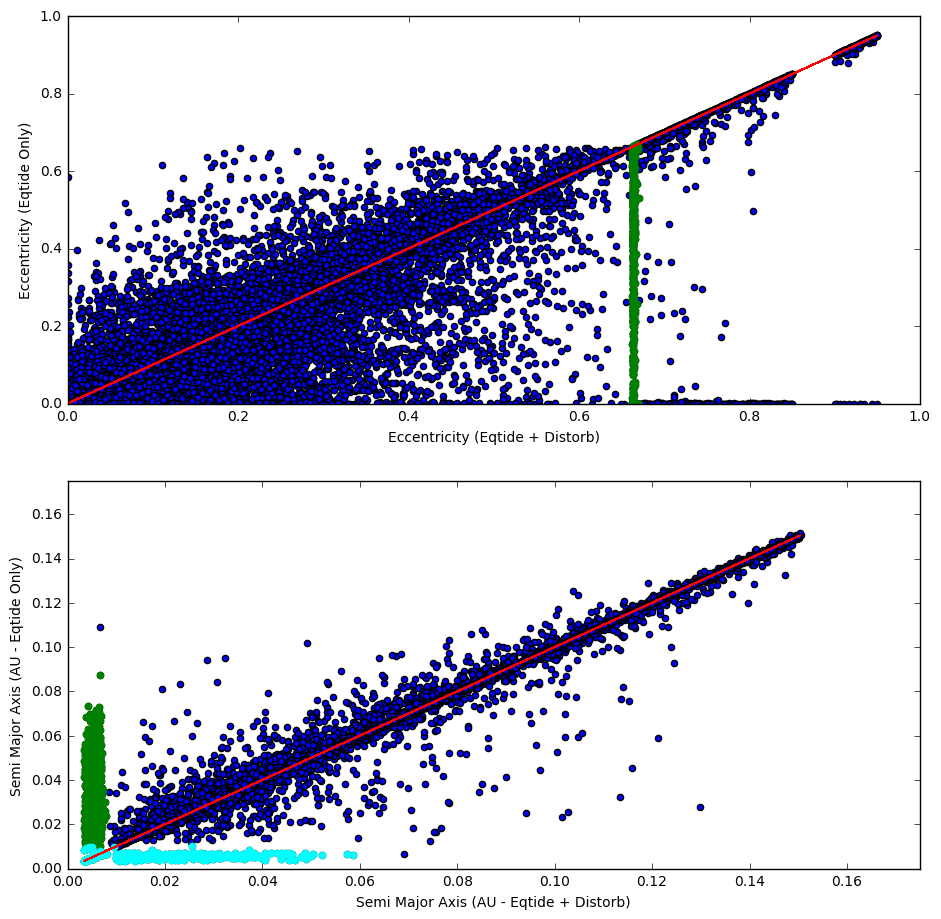

In [53]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(11,11)

#define a few masks
eqorb_greater_ecc = np.where(final['Eq_ecc']<final['Eqorb_ecc']) #Ecc of Eq < Eqorb
eq_greater_ecc = np.where(final['Eq_ecc']>final['Eqorb_ecc']) # Ecc Eq > Eqorb
eqorb_vert_line = np.where((final['Eqorb_ecc']>=0.66) & (final['Eqorb_ecc'] <= 0.67)) # the vertical line where distorb breaks
eqorb_lo_eq_hi = np.where((final['Eqorb_semi']<=0.008)&(final['Eq_semi']<=0.1)) # describes the clusters along the x and y axis below
eqorb_hi_eq_lo = np.where((final['Eqorb_semi']<=0.06)*(final['Eq_semi']<=0.01)) # describes the clusters along the x and y axis below





#plots the data
ax[0].scatter(final['Eqorb_ecc'],final['Eq_ecc'])
ax[1].scatter(final['Eqorb_semi'],final['Eq_semi'])

#reference lines
ax[0].plot(final['Eqorb_ecc'],final['Eqorb_ecc'], color = 'red')
ax[1].plot(final['Eqorb_semi'],final['Eqorb_semi'], color = 'red')

#overlay masks
ax[0].scatter(final['Eqorb_ecc'][eqorb_vert_line],final['Eq_ecc'][eqorb_vert_line], color = 'green')
ax[1].scatter(final['Eqorb_semi'][eqorb_lo_eq_hi],final['Eq_semi'][eqorb_lo_eq_hi], color = 'green')
ax[1].scatter(final['Eqorb_semi'][eqorb_hi_eq_lo],final['Eq_semi'][eqorb_hi_eq_lo], color = 'cyan')


#make it pretty
ax[0].set_ylabel('Eccentricity (Eqtide Only)')
ax[0].set_xlabel('Eccentricity (Eqtide + Distorb)')
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,1)

ax[1].set_ylabel('Semi Major Axis (AU - Eqtide Only)')
ax[1].set_xlabel('Semi Major Axis (AU - Eqtide + Distorb)')
ax[1].set_ylim(0,0.175)
ax[1].set_xlim(0,0.175)

In [9]:
avg_diff_ecc = np.average(final['Diff_ecc'])
avg_diff_semi = np.average(final['Diff_semi'])
avg_diff_ecc
#avg_diff_ecc



-0.025350709936413127

(-0.01, 0.175)

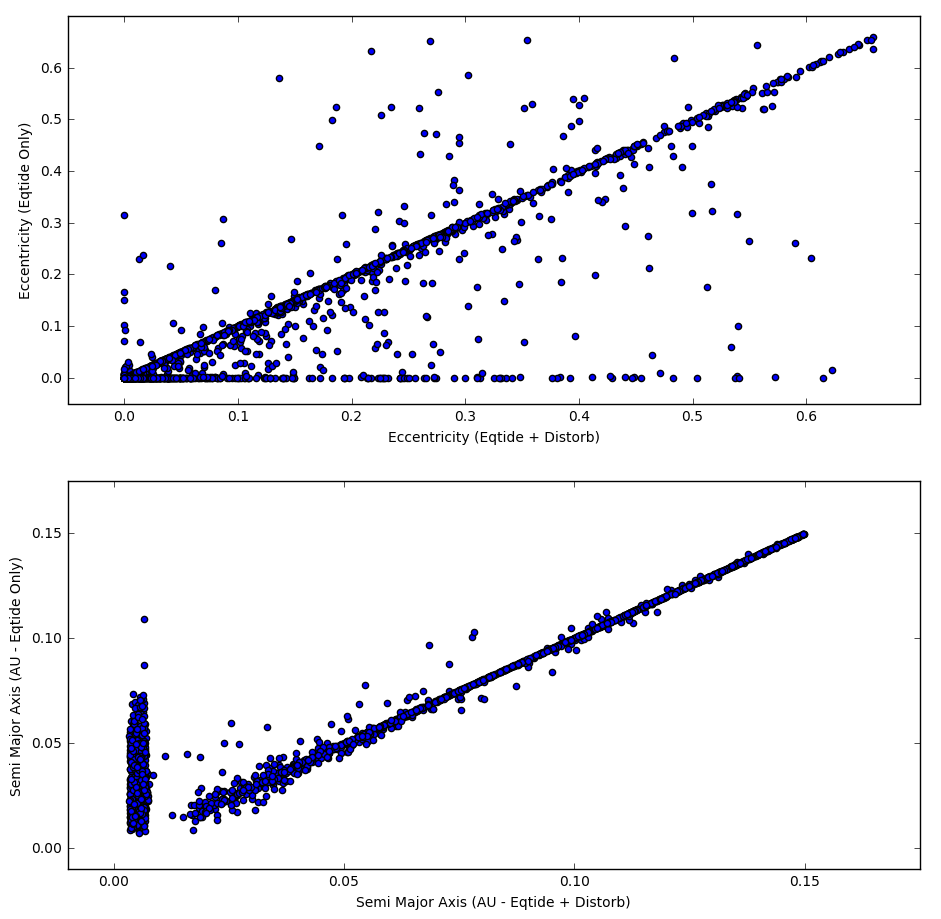

In [60]:
# I want to display which runs merged:
# The masks below will give me those runs,
# Now I just need to see which did NOT merge initially (no perturber)
# and compare to those that DID merge (with perturber)
# and plot various parameters

#final[eqorb_merge_eq_no_merge] # this is the subset of data used below

fig,ax = plt.subplots(2,1)
fig.set_size_inches(11,11)

# mask used below
eqorb_merge_eq_no_merge = np.where((final['Eqorb_age'] < 1e10) & # merged w/ perturber
                                   (final['Eq_age'] == 1e10) &  # no merge w/o perturber
                                   (final['Eqorb_ecc']<0.66)) # the limit for distorb to crash 


# ecc for eq and eqorb
ax[0].scatter(final['Eqorb_ecc'][eqorb_merge_eq_no_merge],final['Eq_ecc'][eqorb_merge_eq_no_merge])
ax[1].scatter(final['Eqorb_semi'][eqorb_merge_eq_no_merge],final['Eq_semi'][eqorb_merge_eq_no_merge])

#make it pretty
ax[0].set_ylabel('Eccentricity (Eqtide Only)')
ax[0].set_xlabel('Eccentricity (Eqtide + Distorb)')
ax[0].set_ylim(-0.05,0.7)
ax[0].set_xlim(-0.05,0.7)

ax[1].set_ylabel('Semi Major Axis (AU - Eqtide Only)')
ax[1].set_xlabel('Semi Major Axis (AU - Eqtide + Distorb)')
ax[1].set_ylim(-0.01,0.175)
ax[1].set_xlim(-0.01,0.175)

In [62]:
# now to compare a and e for each san_check case w/ eqonly case (00857)
san_check_dir = '/home/dm1681/Research/Research/Merging_Perts/comp_san_check/'
s_mass_list = ['nep','sup_ear']
s_res_list = ['long','short']
s_ecc_list = ['circ','ecc']

for mass in s_mass_list:
    for res in s_res_list:
        for ecc in s_ecc_list:
            folder_name = mass+'_'+res+'_'+ecc
            wd = san_check_dir + folder_name
            
            print(wd)

/home/dm1681/Research/Research/Merging_Perts/comp_san_check/nep_long_circ
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/nep_long_ecc
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/nep_short_circ
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/nep_short_ecc
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/sup_ear_long_circ
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/sup_ear_long_ecc
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/sup_ear_short_circ
/home/dm1681/Research/Research/Merging_Perts/comp_san_check/sup_ear_short_ecc


In [ ]:
# determine which merged with the addition of an outer planet:
# # of mergers with eqonly vs eqorb
# a and e for the checks (w/ and w/0 pert)
# solve for a from mass_c and ecc_c from that paper